# R1 / Дом.ру — хакатон

---

**Цель**

Компании **R1** необходимо предсказывать вероятность покупки клиентом нового оборудования.  
Заказчик уже имеет собственное решение (которое не раскрывает), но ищет пути его улучшения.

**Входные данные**

Компания обладает базой клиентов, которым было предложено новое оборудование, а также указано, купил клиент оборудование или нет.

Датасет представляет собой выборку из базы клиентов (**id** – идентификатор клиента), с которыми была
попытка коммуникации в одном из каналов (**channel_name**).

Целевая переменная ('target') равна **1**, если после коммуникации с клиентом была продажа
оборудования и **0**, если нет.

Поле **period** соответствует месяцу сбора признаков на клиента. Лаг между датой коммуникации и сборкой
признаков на клиента – 2 месяца (например, если коммуникация была в любой день марта, то признаки на
клиента собирались на 31 января).

В архиве представлены 2 датасета: dataset_train.parquet (с целевой переменной) и dataset_oot.parquet
(отложенная выборка без целевой переменной)
Все предоставленные данные:

    dataset_train.parquet — тренировочный датасет;
    features_oot.parquet — тестовый датасет;
    features_types.json — словарь типов данных для признаков;
    sample_submission.csv — пример файла с загружаемыми результатами.

Описание признаков

Для каждой пары 'id' + 'period' собрано около 2800 признаков.  
Названия признаков интерпретируются следующим образом:

    <модуль>\_<номер признака>\_<глубина агрегации>\_<тип>

Если признак построен как агрегат (например сумма за период), то указывается **<глубина агрегации>** в
месяцах, в противном случае ставится 0.<br> Также, в качестве **<глубина агрегации>** может быть запись вида
**3d6**, что указывает на отношение агрегата за 3 месяца к агрегату за 6 месяцев.

Типы признаков:

    flg: флаг (значение 1 или 0)
    ctg: категориальный признак
    num: числовой признак
    dt: дата
    cnt: количество
    sum: сумма
    avg: среднее
    sumpct: персентиль по сумме
    part: доля

---

**Задачи:**  

Придумать решение на базе предоставленных данных, которое было бы интересно заказчику.  
Решение реализовать в виде модели.  
Сделать оценку качества модели и описать ее преимущества.

## Intro

## Initial

### Imports

In [1]:
# !pip install scikit-learn --upgrade

In [2]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from pyarrow.parquet import ParquetFile
import duckdb

import warnings
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import RFECV, RFE

from catboost import CatBoostClassifier, cv, Pool

<a id="id_contstants"></a>
### Constants

In [3]:
# common constants

CR = '\n'                                              # new line
RS = RANDOM_STATE = RANDOM_SEED = 888                  # random_state

In [4]:
# path constants

PATH_SWITCH = 'local'                                  # available options are 'local' or 'remote' to choose data source
PATH_LOCAL = 'datasets/'                               # local path to data
PATH_REMOTE = '/kaggle/input/mydatasets/'              # remote path to data

PATH = PATH_LOCAL if PATH_SWITCH == 'local' else PATH_REMOTE  # choose whether local or remote path to data

In [5]:
NAN_THRESHOLD = 0.2                                    # допустимая доля пропусков в одном признаке
STD_MIN_THRESHOLD = 0.02                               # минимально допустимое значение стандартного отклонения для признака
STD_MAX_THRESHOLD = 1.00                               # максимально допустимое значение стандартного отклонения для признака
                                                       # (при 1 этот порог не применяется, но можно поэкспериментировать)

TARGET = 'target'                                      # target name
TRAIN_FRAC = 0.70                                      # train sampling fraction

N_FEATURES_TO_SELECT = 50                              # сколько признаков необходимо отобрать
N_RFECV_ITERATIONS = 7                                 # количество повторных запусков RFECV для feature selection

### Functions

In [6]:
def load_data(data_name, file_extension='parquet', separator=',', query=''):
    '''
    чтение данных из файла с указанным расширением:
       сначала по локальному пути;
       при неудаче — из удаленного хранилища.
    '''

    print(f'{f.BOLD}{data_name}{f.END} in progress...')
    
    path_local = f'{PATH_LOCAL}{data_name}.{file_extension}'
    path_remote = f'{PATH_REMOTE}{data_name}.{file_extension}'
    
    for path in [path_local, path_remote]:
        if os.path.exists(path):
            df = pd.read_parquet(path)
#             df = reduce_memory_usage(df, verbose='short')                             # оптимизация размера занимаемой памяти
            print(f'{f.BOLD}{data_name}{f.END} successfully loaded from {path}{CR}')        
            return df

    print(f'File "{file_name}" not found')

In [7]:
def reduce_memory_usage(df: pd.DataFrame, verbose='full'):
    '''
    Уменьшение памяти, отведенной под хранение датафрейма.
    Вывод отчета: полного или сокращенного.
    '''
    start_mem = df.memory_usage().sum() / 1024**2

    numerical_columns = df.select_dtypes(include=np.number).columns.to_list()

    for col in numerical_columns:
        if verbose == 'full':
            print(f'Optimising column {f.BOLD}{col}{f.END}', end='... ')

        min_value, max_value = df[col].min(), df[col].max()

        if 'int' in str(df[col].dtype):
            int_types = ['int8', 'int16', 'int32', 'int64']
            for int_type in int_types:
                if min_value > np.iinfo(int_type).min and max_value < np.iinfo(int_type).max:
                    df[col] = df[col].astype(int_type)
                    break

        if 'float' in str(df[col].dtype):
            float_types = ['float16', 'float32', 'float64']
            for float_type in float_types:
                if min_value > np.finfo(float_type).min and max_value < np.finfo(float_type).max:
                    df[col] = df[col].astype(float_type)
                    break

        if verbose == 'full':
            print('Done')

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose == 'short':
        print(f'Memory usage before optimization: {start_mem:.3f} MB')
        print(f'Memory usage after optimization: {end_mem:.3f} MB')
        print(f'Memory usage reduced about {(start_mem-end_mem)/start_mem:.0%}')

    return df

### Settings

In [8]:
# text styles
class f:
    BOLD = "\033[1m"
    ITALIC = "\033[3m"
    END = "\033[0m"

In [9]:
# charts defaults

# Matplotlib, Seaborn
PLOT_DPI = 150  # dpi for charts rendering 
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plt.rc(
       'axes',
       labelweight='bold',
       titlesize=16,
       titlepad=10,
      )

In [10]:
# Pandas
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.colheader_justify = 'left'

In [11]:
# others
warnings.filterwarnings('ignore')

---

## Изучение данных

### Признаки

#### Список признаков

In [12]:
data_col_list = ParquetFile(f'{PATH_LOCAL}dataset_train.parquet').schema.names

data_col_list[:7]

['id',
 'period',
 'channel_name',
 'target',
 'markers_0_1_cnt',
 'markers_1_1_cnt',
 'markers_2_1_cnt']

#### Группы признаков

In [13]:
# набор признаков

data_col_set = set(item.split('_')[0] for item in data_col_list)
list(data_col_set)

['target',
 'agreement',
 'cities',
 'type',
 'period',
 'spas',
 'plan',
 'domru',
 'tariff',
 'exist',
 'area',
 'deact',
 'balance',
 'traffic',
 'charges',
 'info',
 'campaigns',
 'materials',
 'markers',
 'autopay',
 'arpu',
 'basic',
 'online',
 'migrant',
 'save',
 'scheme',
 'id',
 'payments',
 'channel',
 'communication',
 'movix',
 'social',
 'vas',
 'user',
 'smarttv',
 'issues',
 'overdue']

In [14]:
# словарь признаков с частотой повторений

data_col_dict = {}

for item in (item.split('_')[0] for item in data_col_list):
    data_col_dict[item] = data_col_dict.get(item, 0) + 1

df = pd.DataFrame(data_col_dict.values(), index=data_col_dict.keys(), columns=['count']).sort_values('count', ascending=False)
df
    
# data_col_dict = dict(sorted(data_col_dict.items(), key=lambda x: x[1], reverse=True))   # упорядочивание по убыванию частоты
# print(json.dumps(data_col_dict, indent=1), f'{CR}')

,count
markers,924
spas,599
campaigns,406
movix,188
issues,159
communication,70
traffic,69
user,69
vas,59
payments,51


#### features_types

In [15]:
(
    pd.read_json(f'{PATH_LOCAL}/features_types.json', typ='series')
    .reset_index()
    .groupby(0)
    .agg(type_count=('index','count'))
    .sort_values('type_count')
)

,type_count
0,
categorical_str,31
categorical_int,138
numeric,2607


... либо так:

In [16]:
schema = pd.read_json(f'{PATH_LOCAL}/features_types.json', typ='series')
schema.unique()

array(['numeric', 'categorical_str', 'categorical_int'], dtype=object)

In [17]:
numeric = schema[schema=='numeric'].index.to_list()
categorical_str = schema[schema=='categorical_str'].index.to_list()
categorical_int = schema[schema=='categorical_int'].index.to_list()

In [18]:
len(numeric), numeric[:3]

(2607, ['markers_0_1_cnt', 'markers_1_1_cnt', 'markers_2_1_cnt'])

In [19]:
len(categorical_str), categorical_str[:3]

(31,
 ['materials_details_0_1_ctg',
  'materials_details_1_1_ctg',
  'user_lifetime_0_1_ctg'])

In [20]:
len(categorical_int), categorical_int[:3]

(138,
 ['communication_availability_0_1_flg',
  'communication_availability_1_1_ctg',
  'communication_availability_2_1_flg'])

### **dataset_train**

In [21]:
metadata = pq.read_metadata(f'{PATH_LOCAL}dataset_train.parquet')
metadata

  created_by: parquet-cpp-arrow version 11.0.0
  num_columns: 2780
  num_rows: 702086
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 1599234

In [22]:
%%time

train_file_path = f'{PATH_LOCAL}dataset_train.parquet'
n_rows = 100_000
period_start = '202210'
channel_name = '3'

query_text = f'''
    SELECT *
    FROM "{train_file_path}"
    WHERE period >= {period_start} AND channel_name = {channel_name}
    ORDER BY RANDOM()
    LIMIT {n_rows};
'''

data_train = duckdb.query(query_text).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: total: 16.6 s
Wall time: 21 s


In [23]:
data_train.period.value_counts()

202211    16171
202210    15432
202212    14335
Name: period, dtype: int64

In [24]:
data_train.channel_name.value_counts()

3    45938
Name: channel_name, dtype: int64

In [25]:
# альтернативный вариант чтения данных

# data_train = pd.read_parquet(
#                              f'{PATH_LOCAL}dataset_train.parquet',
#                              columns=['id'] + [col for col in data_col_list if col.startswith('info')],
#                              memory_map=True,
#                              filters=[('id', '<',  '1100000')]
#                             )

### Баланс классов

In [26]:
data_train[TARGET].value_counts(normalize=True)

0   0.979
1   0.021
Name: target, dtype: float64

In [27]:
from sklearn.utils.class_weight import compute_class_weight

# Вычисление весов классов
class_weights = compute_class_weight('balanced', classes=np.unique(data_train[TARGET]), y=data_train[TARGET])
class_weights

array([ 0.5107173 , 23.82676349])

### Признак `period`

In [28]:
data_train[['period']].describe()

,period
count,45938.000
mean,202210.976
std,0.805
min,202210.000
25%,202210.000
50%,202211.000
75%,202212.000
max,202212.000


Сравнение `period` в обучающей и тестовой выборке.

In [29]:
data_period_train = pd.read_parquet(
                                    f'{PATH_LOCAL}dataset_train.parquet',
                                    columns=['id','period'],
                                   )
data_period_train.shape

(702086, 2)

In [30]:
data_period_oot = pd.read_parquet(
                                  f'{PATH_LOCAL}features_oot.parquet',
                                  columns=['id','period'],
                                 )
data_period_oot.shape

(60661, 2)

In [31]:
data_period_train.groupby('period').agg(period_count=('period','count'))

,period_count
period,
202201,27248
202202,25315
202203,29917
202204,20704
202205,26423
202206,20747
202207,50593
202208,59506
202209,20993


In [32]:
data_period_oot.groupby('period').agg(period_count=('period','count'))

,period_count
period,
202301,20467
202302,19648
202303,20546


> Признак `period` включает год и месяц.  
> Обучающая и тестовая выборки связаны хронологически: данные в тестовой получены после обучающей.
>
> Попробовать взять только часть информации.  
> Например, за последние 2-3 месяца.

### Признак `channel` 

In [33]:
data_channel_oot = pd.read_parquet(
                                   f'{PATH_LOCAL}features_oot.parquet',
                                   columns=['id','channel_name'],
                                  )

In [34]:
data_channel_train = pd.read_parquet(
                                   f'{PATH_LOCAL}dataset_train.parquet',
                                   columns=['id','channel_name',TARGET],
                                  )

In [35]:
data_channel_oot.channel_name.value_counts()

3    60661
Name: channel_name, dtype: int64

In [36]:
data_channel_train.channel_name.value_counts()

5    221058
3    209022
4    135852
1    131566
2      4588
Name: channel_name, dtype: int64

In [37]:
data_channel_train.groupby('channel_name').agg(target=('target','mean'))

,target
channel_name,
1,0.004
2,0.005
3,0.016
4,0.005
5,0.004


### Небольшие улучшения

#### Новый признак `communique_num`

Проверка версии: "Вероятность сделки растет с увеличением числа коммуникаций с клиентом".  
Проверка будет на всех записях обучающего датасета.

In [38]:
data_id_period = pd.read_parquet(
                                 f'{PATH_LOCAL}dataset_train.parquet',
                                 columns=['id','period','target'],
                                )

In [39]:
data_id_period.sort_values(['id','period'], inplace=True)

# новый признак 'communique_num' нарастающий итог коммуникаций с клиентом
data_id_period['communique_num'] = data_id_period.groupby('id').cumcount() + 1

In [40]:
data_id_period[data_id_period.target == 1].value_counts('communique_num')

communique_num
1    4602
2     734
3     118
4      14
5       1
dtype: int64

> Похоже, версия не подтвердилась ((

#### Тип данных для категориальных полей

In [41]:
data_train[categorical_str] = data_train[categorical_str].astype('category')
data_train[categorical_int] = data_train[categorical_int].astype('category')

In [42]:
data_train[categorical_str].iloc[:,:3].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45938 entries, 0 to 45937
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   materials_details_0_1_ctg  45938 non-null  category
 1   materials_details_1_1_ctg  45938 non-null  category
 2   user_lifetime_0_1_ctg      45938 non-null  category
dtypes: category(3)
memory usage: 138.0 KB


In [43]:
data_train[categorical_int].iloc[:,:3].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45938 entries, 0 to 45937
Data columns (total 3 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   communication_availability_0_1_flg  45938 non-null  category
 1   communication_availability_1_1_ctg  45938 non-null  category
 2   communication_availability_2_1_flg  45938 non-null  category
dtypes: category(3)
memory usage: 135.3 KB


#### Оптимизация типов данных

In [44]:
%%time

# data_train = reduce_memory_usage(data_train, verbose='short')

CPU times: total: 0 ns
Wall time: 0 ns


> Факты из описания заказчика.
> 1. Набор признаков постоянно меняется: одни остаются, другие исчезают (например, связанные с разовыми акциями). Активно генерируются новые признаки.
> 2. Признаки создаются различными путями, в том числе генерацией производных признаков за разные временные промежутки.
> 3. С течением времени значения признаков могут изменяться и, как следствие, изменяется значимость этих признаков.
> 4. Регулярно осуществляется повторное обучение модели на новых данных.
> 5. Для заказчика приемлемо определенное значение метрики, определяющей качество модели. Основной метрикой выбрана ROC-AUC.
>
> Принимая во внимание вышеописанные факты, было принято решение сосредоточиться на сокращении количества признаков, используемых для моделирования, при сохранениии требуемого качества модели.
> 
> Премущества такого решения:
> 1. Закачик сможет регулярно обучать модель, затрачивая меньшее количество ресурсов.
> 2. Заказчик получит более стабильную серию моделей, легче поддающихся анализу.
> 3. Заказчик сможет скорректировать процесс генерации новых признаков.
> 4. Закачик сможет сосредоточиться на улучшении качества модели, благодаря существенному сокращению требуемых ресурсов для вычислений.

## Предобработка

### Удаление признаков с пропусками

Удаление признаков с долей пропусков выше определенного порога.

In [45]:
data_train.shape

(45938, 2780)

In [46]:
df = (data_train.drop(TARGET, axis=1).isna().sum() / data_train.shape[0]).sort_values(ascending=False)
df.sample(3)

markers_909_1_cnt             0.060
traffic_details_47_3_sum      0.029
spas_symptoms_agr_252_1_std   0.010
dtype: float64

In [47]:
drop_feature_list = df[df > NAN_THRESHOLD].index.to_list()

data_train = data_train.drop(drop_feature_list, axis=1)

In [48]:
data_train.shape

(45938, 2236)

> Поскольку поставленная цель — сокращение количества признаков, то первым делом произведено исключение признаков с большим количеством пропущенных значений.
>
> Допустимое количество пропусков сохранено в константе `NAN_THRESHOLD` и может быть настроено по усмотрению закачика.  
> В данном проекте используется `NAN_THRESHOLD = 0.2`

### Константные признаки

Можно прихватить и признаки с низкой дисперсией, регулируя порог.  
Можно и слишком высокодисперсионные удалить.

In [49]:
def find_columns_with_same_values(df):
    '''
    Функция на тот случай, если определения константности признака по STD будет недостаточно.
    Например, для данных типа object.
    '''
    columns_with_same_values = []
    
    for column in df.columns:
        if df[column].nunique() == 1:
            columns_with_same_values.append(column)
            
    return columns_with_same_values


len(find_columns_with_same_values(data_train))    # для сравнения результата функции с результатом метода std

227

In [50]:
%%time

scaler = MinMaxScaler().fit(data_train.select_dtypes(include='number'))

df = pd.DataFrame(scaler.transform(data_train.select_dtypes(include='number')), columns=data_train.select_dtypes(include='number').columns).std()

df.head(3)

CPU times: total: 1 s
Wall time: 1.32 s


period            0.402
target            0.143
markers_0_1_cnt   0.029
dtype: float64

In [51]:
df[df == 0].shape[0]

226

In [52]:
df[df <= STD_MIN_THRESHOLD].shape[0]

877

In [53]:
df[df >= STD_MAX_THRESHOLD].shape[0]

0

In [54]:
drop_feature_list = df[(df <= STD_MIN_THRESHOLD) | (df >= STD_MAX_THRESHOLD)].index.to_list()

len(drop_feature_list)

877

In [55]:
data_train = data_train.drop(drop_feature_list, axis=1)

data_train.shape

(45938, 1359)

> Следующим шагом исключены признаки с низкой и высокой дисперсией.
>
> Допустимый диапазон значений стандартного отклонения сохранен в константах `STD_MIN_THRESHOLD` и `STD_MAX_THRESHOLD` и может быть настроен по усмотрению закачика.
> 
> В данном проекте используется `STD_MIN_THRESHOLD = 0.02` и `STD_MIN_THRESHOLD = 1` (т.е. фактически высокодисперсионные признаки не исключаются).

### Заполнение пропусков

In [56]:
# data_train.isna().sum()

In [57]:
# data_train = data_train.fillna(0)

Следующий метод подходит только для небольших датасетов.

In [58]:
# imputer = IterativeImputer(verbose=3, random_state=RS)
# imputer.fit(data_train)
# imputer_data = imputer.transform(data_train)
# imputer_data = pd.DataFrame(imputer_data,columns=new_data.columns)

> Пока не применяется.  
> Для CatBoost используется внутренний алгоритм.  
> Если потребуется, нужно применить заполнение пропусков к очищенному датасету.

## Подготовка данных для модели

### Выделение признаков и целевой переменной

In [59]:
X = data_train.drop(['id', TARGET], axis=1)
Y = data_train[TARGET]

X.shape, Y.shape

((45938, 1357), (45938,))

In [60]:
cat_features = X.select_dtypes(exclude='number').columns.to_list()
cat_features[:5]

['channel_name',
 'materials_details_0_1_ctg',
 'materials_details_1_1_ctg',
 'user_lifetime_0_1_ctg',
 'tariff_plans_12_1_ctg']

> Так можно сделать, поскольку ранее все численные категориальные признаки были приведены к типу `category`.

### Разделение на обучающую и валидационную выборки

In [61]:
# X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=TRAIN_FRAC, stratify=Y, random_state=RS)

# X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

In [62]:
splitter = GroupShuffleSplit(n_splits=1, train_size=TRAIN_FRAC, random_state=RS)
id_groups = data_train.id

train_idx, valid_idx = next(splitter.split(X, Y, groups=id_groups))

X_train = X.loc[train_idx, :]
X_valid = X.loc[valid_idx, :]

Y_train = Y[train_idx]
Y_valid = Y[valid_idx]

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((32153, 1357), (13785, 1357), (32153,), (13785,))

In [63]:
Y_train.value_counts(normalize=True), Y_valid.value_counts(normalize=True)

(0   0.979
 1   0.021
 Name: target, dtype: float64,
 0   0.979
 1   0.021
 Name: target, dtype: float64)

In [64]:
# проверка: в X_train и X_valid нет одинаковых 'id'
# (предварительно для X_train и X_valid присоединяется прихнак 'id' из data_train)

X_train.join(data_train['id']).merge(X_valid.join(data_train['id']), on='id').shape

(0, 2715)

> `GroupShuffleSplit` гарантирует, что один и тот же клиент (с одинаковым `id`) попадет либо в test, либо в valid.

### Пайплайн предобработки

In [65]:
# num_selector = make_column_selector(dtype_include='number')
# cat_selector = make_column_selector(dtype_exclude='number')

In [66]:
# num_preprocessor = make_pipeline(
#                                  SimpleImputer(strategy='median'),
#                                  RobustScaler(),
#                                 )

# cat_preprocessor_linr = make_pipeline(
#                                       SimpleImputer(strategy='most_frequent'),
#                                       OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', max_categories=10),
#                                      )

# cat_preprocessor_tree = make_pipeline(
#                                       SimpleImputer(strategy='most_frequent'),
#                                       OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, max_categories=10)
#                                      )

In [67]:
# preprocessing_linr = make_column_transformer(
#                                              (num_preprocessor, num_selector),
#                                              (cat_preprocessor_linr, cat_selector),
#                                             )

# preprocessing_tree = make_column_transformer(
#                                              (num_preprocessor, num_selector),
#                                              (cat_preprocessor_tree, cat_selector),
#                                             )

# # preprocessing_catBoost = make_column_transformer(
# #                                              (num_preprocessor, num_selector),
# #                                             )

In [68]:
# X_train = preprocessing_linr.fit_transform(X_train)
# X_valid = preprocessing_linr.transform(X_valid)

In [69]:
# X_train.shape

> Поскольку далее используется Catboost, пайплайн предобработки не задействован.  
> Пока оставлю: возможно, потребуется.

### Feature Selection

#### RFECV

In [70]:
def plot_reduce_feature_list(feature_selection, iteration_num):
    '''
    Выводит график зависимости метрики от количества отобранных признаков
    '''
    n_scores = len(feature_selection.cv_results_['mean_test_score'])

    fig, ax = plt.subplots(figsize=(15,4), dpi=PLOT_DPI)
    plt.xlabel('Number of features selected')
    plt.ylabel('Mean test score')
    plt.errorbar(
                 np.linspace(N_FEATURES_TO_SELECT, feature_selection.n_features_in_, n_scores),
                 feature_selection.cv_results_['mean_test_score'],
                 yerr=feature_selection.cv_results_['std_test_score'],
                )
    plt.title(f'RFECV selected {feature_selection.n_features_} features on {iteration_num} iteration')
    plt.show()

In [71]:
def reduce_feature_list(X, iteration_num):
    '''
    Делает отбор признаков с помощью RFECV.
    Количество отобранных признаков может быть больше количества,
    задаваемого параметром min_features_to_select (передается константой N_FEATURES_TO_SELECT).
    '''
    estimator = CatBoostClassifier(
    #                                cat_features=cat_features,
                                   eval_metric='AUC',
                                   iterations=100,
                                   one_hot_max_size=10,
                                   random_seed=RS,
                                   verbose=False,
                                  )
    
    n_splits = min(2 + iteration_num, 5)        # для первых итераций отбора признаков достаточно меньшего количества фолдов,
    cv = StratifiedKFold(n_splits=n_splits)     # но в любом случае не более 5 фолдов

    feature_selection = RFECV(estimator, min_features_to_select=N_FEATURES_TO_SELECT,
                              step=0.02, scoring='roc_auc', cv=cv, verbose=0, n_jobs=-1)

    feature_selection.fit(X, Y)

    selected_features = X.loc[:, feature_selection.support_].columns.to_list()
    X = X.loc[:, feature_selection.support_]

    plot_reduce_feature_list(feature_selection, iteration_num + 1)
    X.info(verbose=False, memory_usage='deep')
    print()
    
    return X, selected_features

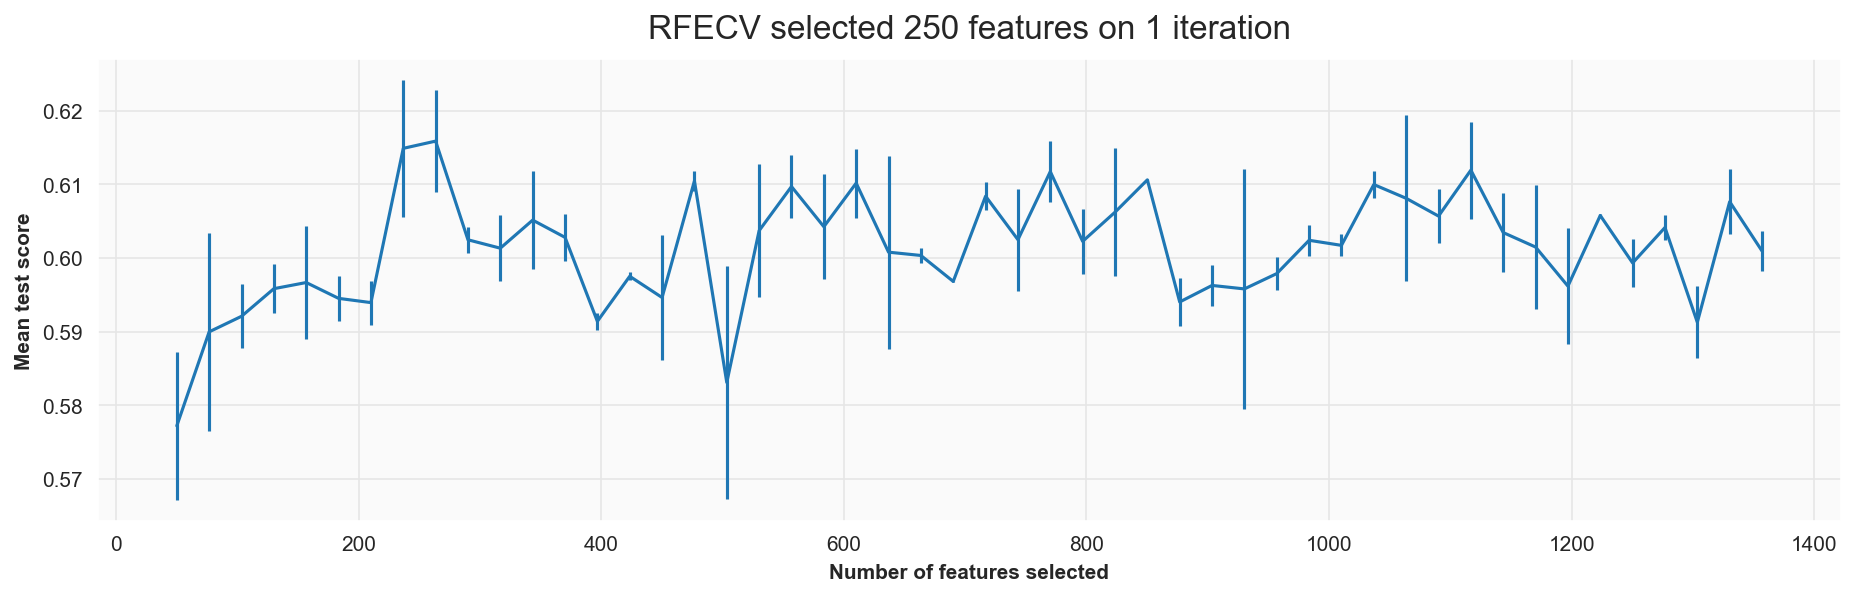

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45938 entries, 0 to 45937
Columns: 250 entries, markers_22_1_cnt to user_active_34_1_flg
dtypes: category(42), float64(208)
memory usage: 75.3 MB



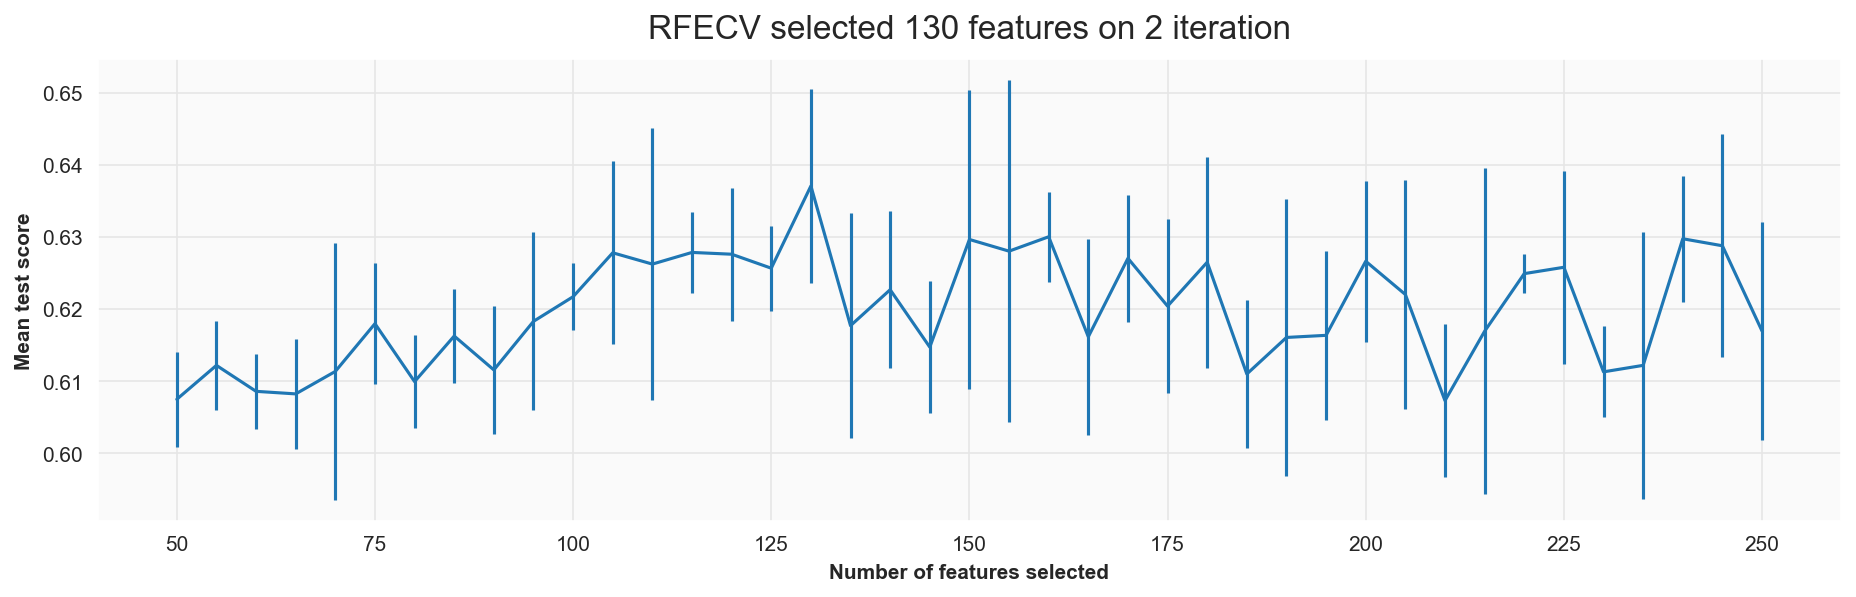

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45938 entries, 0 to 45937
Columns: 130 entries, markers_22_1_cnt to tariff_plans_24_src_id
dtypes: category(9), float64(121)
memory usage: 43.3 MB



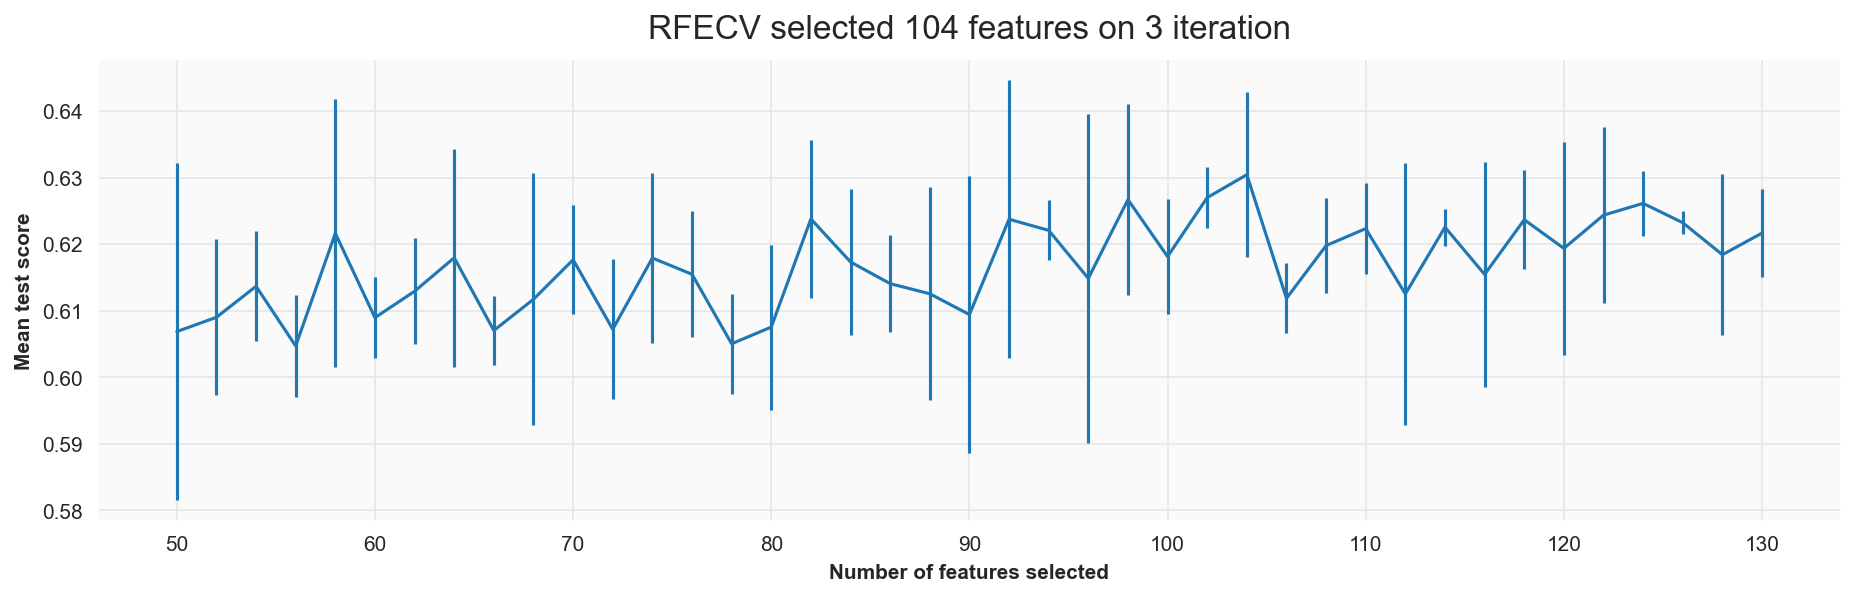

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45938 entries, 0 to 45937
Columns: 104 entries, markers_25_1_cnt to tariff_plans_19_src_id
dtypes: category(8), float64(96)
memory usage: 34.5 MB



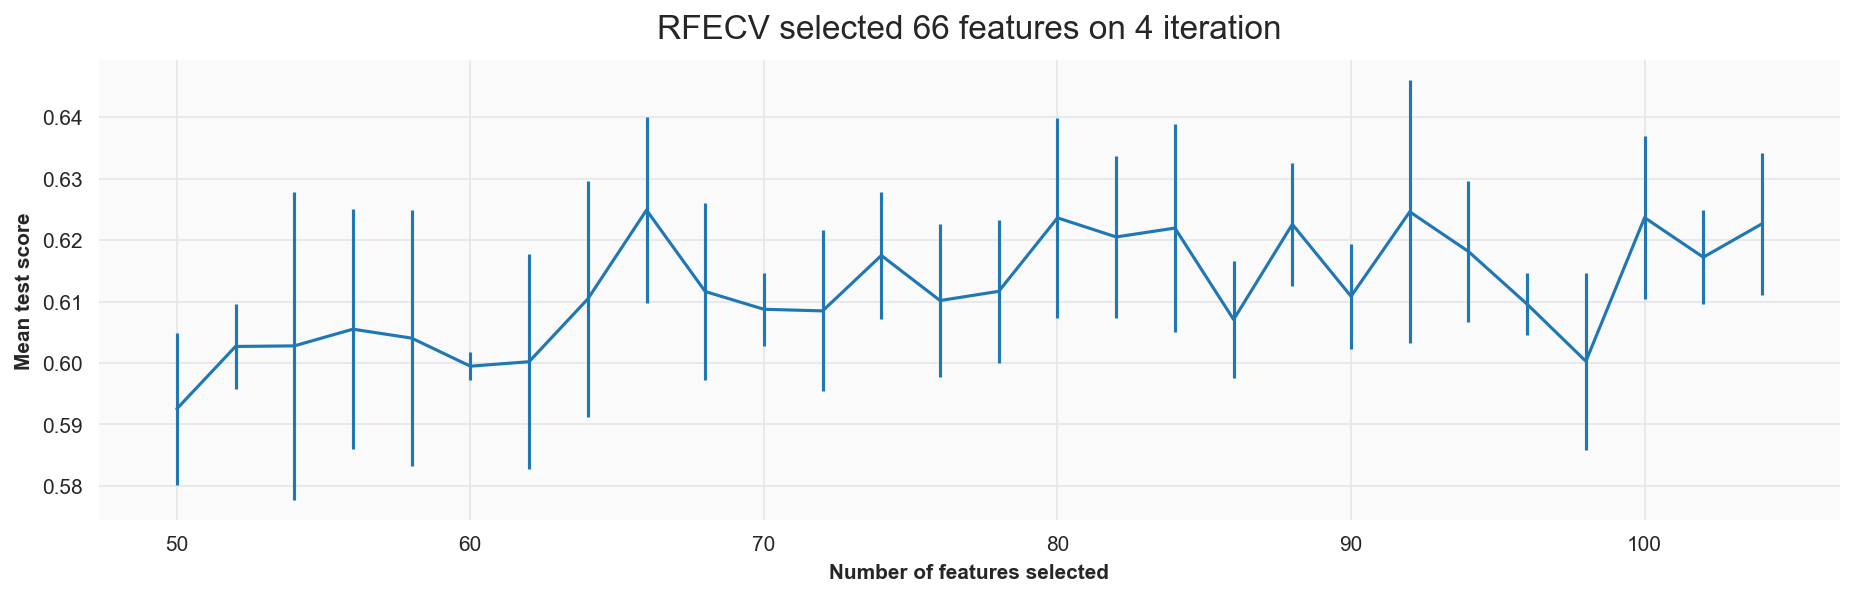

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45938 entries, 0 to 45937
Columns: 66 entries, markers_32_1_cnt to tariff_plans_19_src_id
dtypes: category(8), float64(58)
memory usage: 21.2 MB



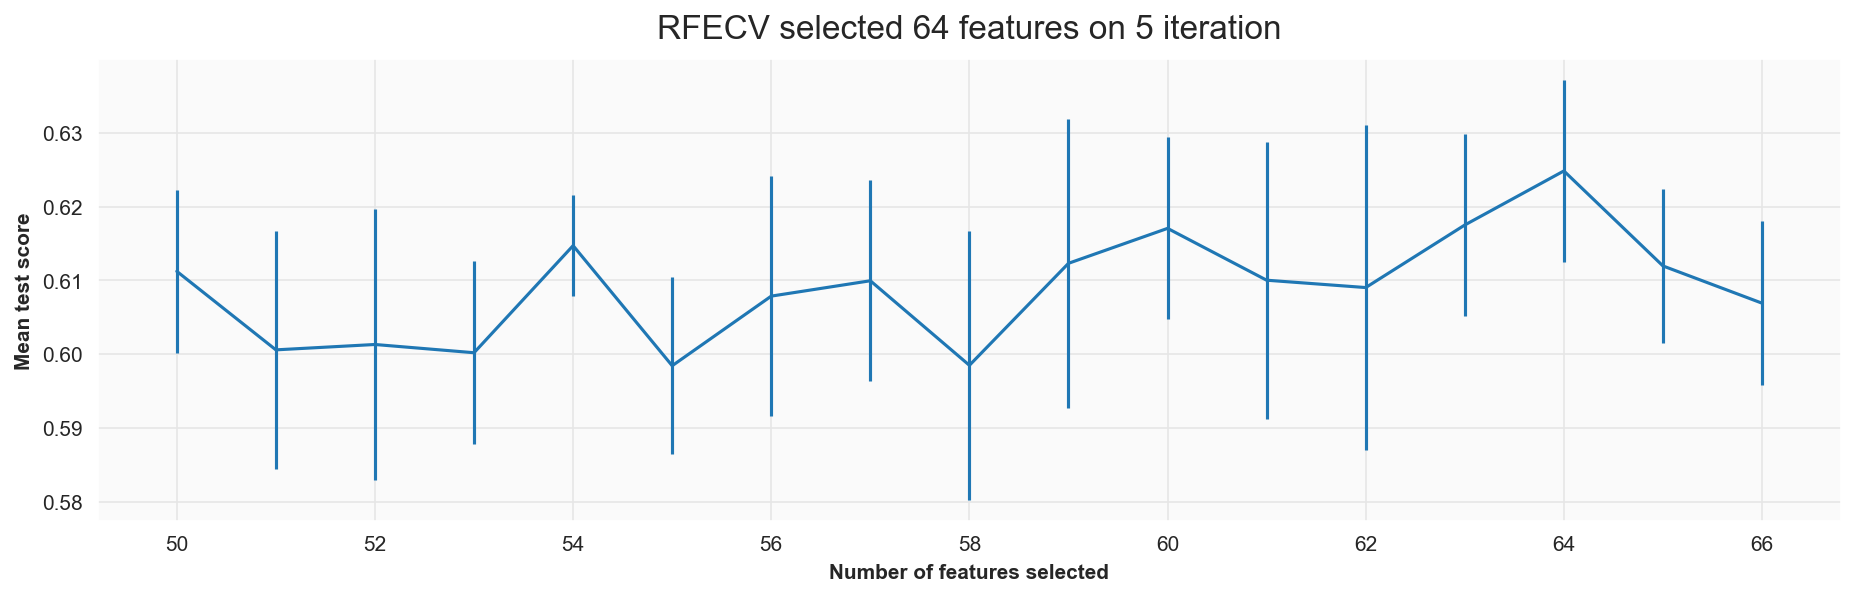

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45938 entries, 0 to 45937
Columns: 64 entries, markers_32_1_cnt to tariff_plans_19_src_id
dtypes: category(8), float64(56)
memory usage: 20.5 MB



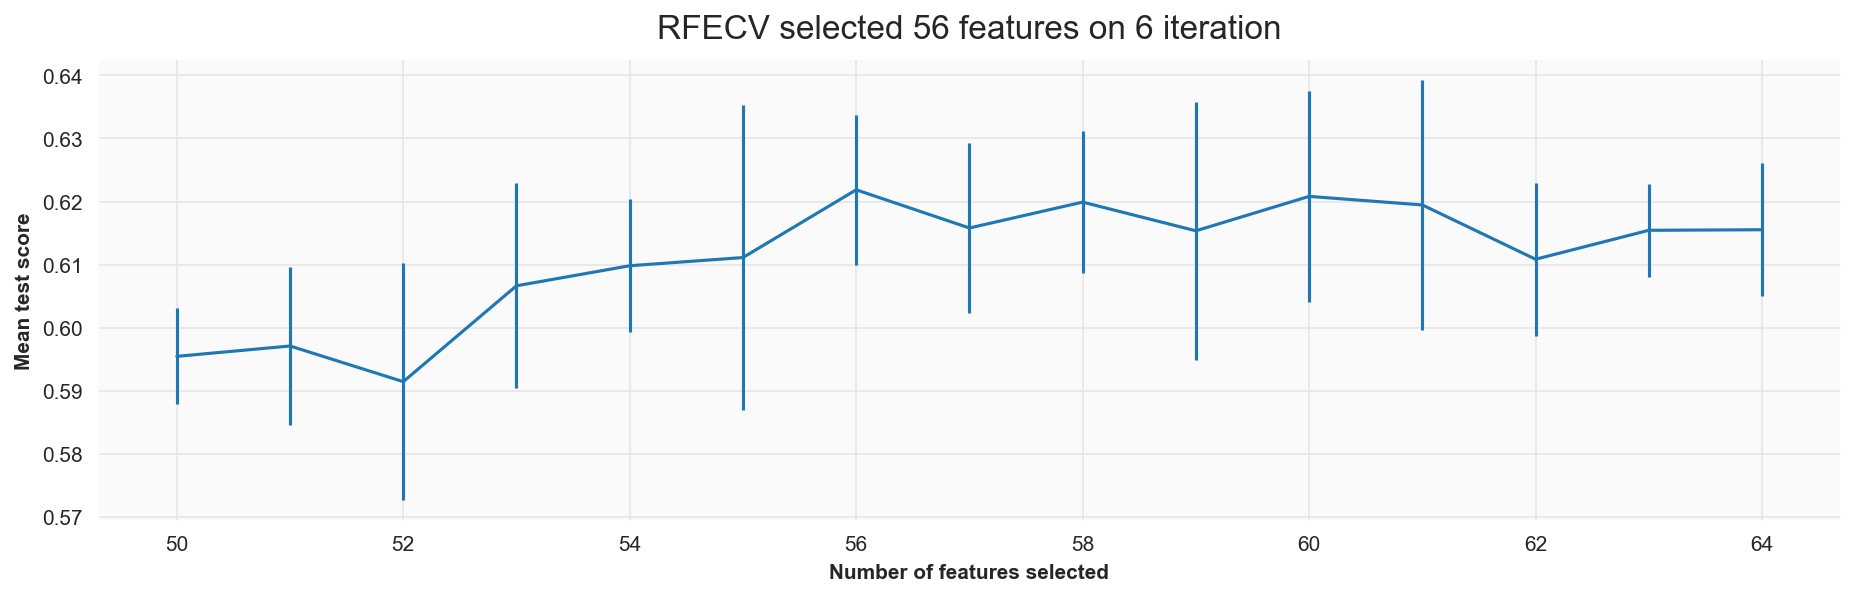

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45938 entries, 0 to 45937
Columns: 56 entries, markers_32_1_cnt to tariff_plans_19_src_id
dtypes: category(7), float64(49)
memory usage: 18.0 MB



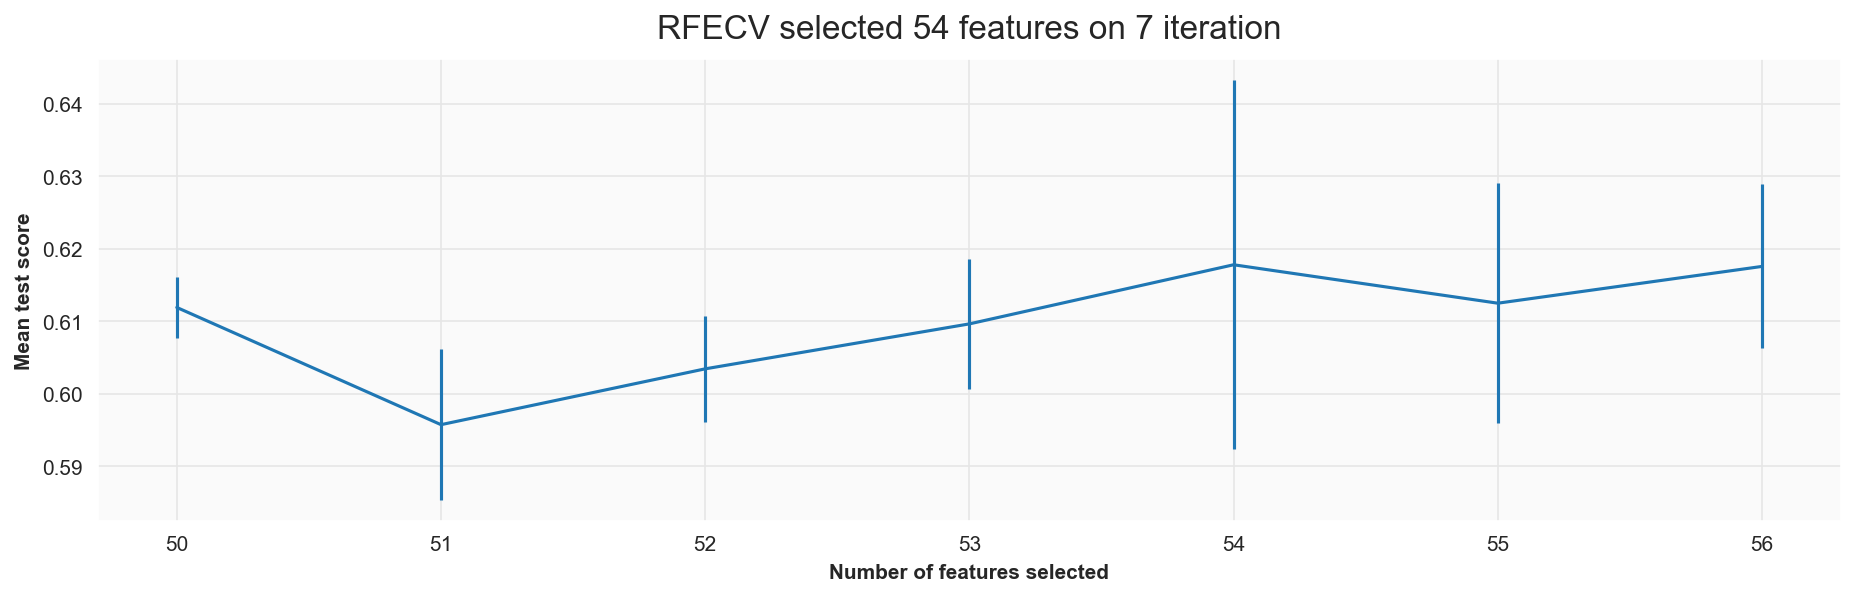

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45938 entries, 0 to 45937
Columns: 54 entries, markers_32_1_cnt to tariff_plans_19_src_id
dtypes: category(6), float64(48)
memory usage: 17.6 MB



In [72]:
for iteration_num in range(N_RFECV_ITERATIONS):                                        # 5 итераций обычно хватает, но можно увеличить
    X, selected_features = reduce_feature_list(X, iteration_num)

> С помощью **RFECV** количество признаков сокращется за несколько итераций.  
> Количество отобранных признаков может быть больше заданного константой `N_FEATURES_TO_SELECT`.

#### RFE

In [73]:
%%time

estimator = CatBoostClassifier(
#                                cat_features=cat_features,
                               eval_metric='AUC',
                               iterations=100,
                               random_seed=RS,
                               verbose=False,
                              )

feature_selection = RFE(estimator, n_features_to_select=N_FEATURES_TO_SELECT, step=0.01, verbose=0)
feature_selection.fit(X, Y)

selected_features = X.loc[:, feature_selection.support_].columns.to_list()

CPU times: total: 4.41 s
Wall time: 6.84 s


> Если на предыдущем этапе количество отобранных признаков оказалось больше заданного константой `N_FEATURES_TO_SELECT`, то с помощью **RFE** отбирается строго заданное количество признаков.

#### Отобранные признаки

In [74]:
if 'period' in selected_features:
    selected_features.remove('period')
    
selected_features

['markers_32_1_cnt',
 'markers_40_1_cnt',
 'markers_72_1_cnt',
 'markers_73_1_cnt',
 'markers_74_1_cnt',
 'markers_102_1_cnt',
 'markers_146_1_cnt',
 'markers_225_1_cnt',
 'markers_293_1_cnt',
 'markers_302_1_cnt',
 'markers_310_1_cnt',
 'markers_334_1_cnt',
 'markers_349_1_cnt',
 'markers_364_1_cnt',
 'markers_508_1_cnt',
 'markers_576_1_cnt',
 'markers_589_1_cnt',
 'markers_706_1_cnt',
 'markers_761_1_cnt',
 'spas_symptoms_agr_10_12_sum',
 'payments_details_28_3_sumpct',
 'charges_details_6_1_sum',
 'tariff_plans_4_1_num',
 'payments_details_33_1_sum',
 'payments_details_46_1_sum',
 'plan_costs_0_1_sum',
 'plan_costs_7_3_avg',
 'spas_symptoms_int_78_1_cnt',
 'spas_symptoms_agr_104_12_avg',
 'spas_symptoms_agr_250_12_sum',
 'campaigns_347_3d6_part',
 'campaigns_363_1d3_part',
 'campaigns_369_6_part',
 'campaigns_374_3d6_part',
 'campaigns_375_6_part',
 'campaigns_377_3_cnt',
 'campaigns_378_6_cnt',
 'campaigns_388_1_part',
 'campaigns_392_3_part',
 'campaigns_400_1d6_part',
 'campaign

In [75]:
len(selected_features)

50

> На всякий случай проверено, нет ли среди отобранных признаков признака `period`.  
> Если есть, он удаляется.

### Загрузка обучающих данных

In [76]:
# train_file_path = f'{PATH_LOCAL}dataset_train.parquet'
# n_rows = 3

# duckdb.query(f'SELECT "markers_30_1_cnt", "markers_32_1_cnt" FROM "{train_file_path}" LIMIT {n_rows};').df()

In [77]:
data_train = pd.read_parquet(
                             f'{PATH_LOCAL}dataset_train.parquet',
                             columns=['id', TARGET] + selected_features,
                             memory_map=True,
                             filters=[('period', '<=',  202211), ('channel_name', '=', '3')]
                            )

In [78]:
data_valid = pd.read_parquet(
                             f'{PATH_LOCAL}dataset_train.parquet',
                             columns=['id', TARGET] + selected_features,
                             memory_map=True,
                             filters=[('period', '>',  202211), ('channel_name', '=', '3')]
                            )

> Данные загружаются заново, включаются только отобранные ранее признаки.  
> До определенной даты данные считаются обучающими, после нее — валидационными.  
> `channel_name = 3` — условие заказчика.

### Выделение признаков и целевой переменной

In [79]:
# X = data_train.drop(['id', TARGET], axis=1)
# # X = data_train.drop(TARGET, axis=1)
# Y = data_train[TARGET]

# X.shape, Y.shape

In [80]:
# X.info()

In [81]:
# Y.info()

### Разделение на обучающую и валидационную выборки

In [82]:
# X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=TRAIN_FRAC, stratify=Y, random_state=RS)

# X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

In [83]:
# splitter = GroupShuffleSplit(n_splits=1, train_size=TRAIN_FRAC, random_state=RS)
# id_groups = data_train.id

# train_idx, valid_idx = next(splitter.split(X, Y, groups=id_groups))

# X_train = X.loc[train_idx, :]
# X_valid = X.loc[valid_idx, :]

# Y_train = Y[train_idx]
# Y_valid = Y[valid_idx]

# X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

In [84]:
X_train = data_train.drop(['id', TARGET], axis=1)
Y_train = data_train[TARGET]

X_valid = data_valid.drop(['id', TARGET], axis=1)
Y_valid = data_valid[TARGET]

> Остановился на простой форме разделения на train и valid — просто по дате.

In [85]:
Y_train.value_counts(normalize=True), Y_valid.value_counts(normalize=True)

(0   0.984
 1   0.016
 Name: target, dtype: float64,
 0   0.980
 1   0.020
 Name: target, dtype: float64)

> Распределение изменилось.  
> Это может быть проблемой, но пока — как есть.
>
> Возможно, для улучшения качества модели стоит применить методы работы с временными рядами.

## Модель CatBoost

In [86]:
model = CatBoostClassifier(
                           iterations=10_000,
#                            cat_features=cat_features,
                           eval_metric='AUC',
                           learning_rate=0.001,
                           early_stopping_rounds=500,
                           random_seed=RS,
                          )

model.fit(
          X_train, Y_train,
          eval_set=(X_valid, Y_valid),
          verbose=200,
          plot=True,
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5865994	best: 0.5865994 (0)	total: 32.5ms	remaining: 5m 25s
200:	test: 0.6459544	best: 0.6461731 (199)	total: 5.9s	remaining: 4m 47s
400:	test: 0.6488487	best: 0.6488487 (400)	total: 11.7s	remaining: 4m 40s
600:	test: 0.6482090	best: 0.6492475 (452)	total: 17.5s	remaining: 4m 33s
800:	test: 0.6496751	best: 0.6497183 (799)	total: 23.5s	remaining: 4m 29s
1000:	test: 0.6491525	best: 0.6498518 (806)	total: 29.4s	remaining: 4m 24s
1200:	test: 0.6493562	best: 0.6498518 (806)	total: 35.4s	remaining: 4m 19s
1400:	test: 0.6499833	best: 0.6500603 (1373)	total: 41.5s	remaining: 4m 14s
1600:	test: 0.6498121	best: 0.6501106 (1430)	total: 47.6s	remaining: 4m 9s
1800:	test: 0.6499735	best: 0.6502032 (1647)	total: 53.7s	remaining: 4m 4s
2000:	test: 0.6496614	best: 0.6502032 (1647)	total: 59.8s	remaining: 3m 59s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6502032177
bestIteration = 1647

Shrink model to first 1648 iterations.


> Метрика всего лишь на 2 п.п. уступает топовому решению, использующему несколько сотен признаков.

In [87]:
# params = {
#           'loss_function': 'Logloss',
#           'custom_loss': 'AUC',
#           'iterations': 1000,
#           'random_seed': RS,
#           # 'learning_rate': 0.01
#          }

# cv_data = cv(
#              params=params,
#              pool=Pool(X_train, Y_train, cat_features=cat_features),
#              early_stopping_rounds=50,
#              fold_count=3,
#              shuffle=True,
#              plot=True,
#              stratified=True, 
#              verbose=200,
#             )

In [88]:
# cv_data.filter(regex='^test').mean().to_frame().T

In [89]:
# cv_data.sort_values('test-AUC-mean', ascending=False)

> Вариант исследования, чтобы подробнее рассмотреть процесс обучения.

## Submit

Этот раздел предназначен исключительно для создания сабмита в соревновании на Kaggle.

### Загрузка тестовых данных

In [90]:
train_file_path = f'{PATH_LOCAL}dataset_oot.parquet'
n_rows = 3

query_text = f'''
    SELECT "markers_30_1_cnt", "markers_32_1_cnt"
    FROM "{train_file_path}"
    LIMIT {n_rows};
'''

duckdb.query(query_text).df()

,markers_30_1_cnt,markers_32_1_cnt
0,-0.088,10.778
1,-0.088,-0.238
2,-0.088,-0.238


In [91]:
data_oot = pd.read_parquet(
                           f'{PATH_LOCAL}features_oot.parquet',
                           columns=['id','period'] + selected_features,
                          )

In [92]:
data_oot.head(3)

,id,period,markers_32_1_cnt,markers_40_1_cnt,markers_72_1_cnt,markers_73_1_cnt,markers_74_1_cnt,markers_102_1_cnt,markers_146_1_cnt,markers_225_1_cnt,markers_293_1_cnt,markers_302_1_cnt,markers_310_1_cnt,markers_334_1_cnt,markers_349_1_cnt,markers_364_1_cnt,markers_508_1_cnt,markers_576_1_cnt,markers_589_1_cnt,markers_706_1_cnt,markers_761_1_cnt,spas_symptoms_agr_10_12_sum,payments_details_28_3_sumpct,charges_details_6_1_sum,tariff_plans_4_1_num,payments_details_33_1_sum,payments_details_46_1_sum,plan_costs_0_1_sum,plan_costs_7_3_avg,spas_symptoms_int_78_1_cnt,spas_symptoms_agr_104_12_avg,spas_symptoms_agr_250_12_sum,campaigns_347_3d6_part,campaigns_363_1d3_part,campaigns_369_6_part,campaigns_374_3d6_part,campaigns_375_6_part,campaigns_377_3_cnt,campaigns_378_6_cnt,campaigns_388_1_part,campaigns_392_3_part,campaigns_400_1d6_part,campaigns_403_3d6_part,user_devices_30_1_cnt,markers_896_1_cnt,markers_902_1_cnt,tariff_plans_16_1_ctg,tariff_plans_18_1_ctg,tariff_plans_23_1_ctg,cities_2_0_ctg,communication_availability_30_1_flg,tariff_plans_19_src_id
0,1548227,202303,2.728,0.134,0.473,2.443,0.880,0.005,-0.126,2.077,-0.205,-0.374,-0.128,-0.241,0.442,-0.426,2.236,1.905,2.839,-0.357,2.466,-0.345,1.676,0.302,-1.045,-0.064,-0.376,-0.933,-0.272,0.480,-0.312,-0.157,-0.616,-0.555,-0.729,-0.462,-0.457,1.562,1.474,-0.204,-0.191,-0.791,-2.206,-0.431,-0.359,-0.337,423,2601,320,52,1,51675
1,1173554,202302,-0.238,-0.401,-0.182,-0.464,0.449,-0.355,-0.126,1.835,-0.487,-0.374,-0.726,-0.521,-0.411,-0.426,-0.532,-0.597,-0.363,-0.357,-0.198,-0.366,1.610,0.313,-1.638,-0.994,-1.282,-0.151,-0.272,0.266,-0.312,-0.157,-0.616,1.705,-0.636,-0.462,-0.457,2.386,1.939,-0.356,0.221,-0.791,-0.021,-0.431,-0.359,-0.337,423,4733,310,52,1,51439
2,1370450,202303,-0.238,-0.401,0.473,-0.464,0.880,-0.355,1.766,-0.340,-0.487,-0.128,-0.726,-0.521,0.158,-0.426,-0.532,-0.471,-0.363,-0.357,-0.198,2.944,-0.293,-9.053,-2.499,-0.146,-0.457,-1.455,0.081,0.695,-0.312,0.863,-0.616,-0.555,-0.702,-0.462,-0.457,1.081,0.750,-1.435,-1.055,-0.791,0.739,-0.431,-0.359,-0.337,1143,2647,215,52,1,51654


In [93]:
data_oot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60661 entries, 0 to 60660
Data columns (total 52 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   60661 non-null  object 
 1   period                               60661 non-null  int32  
 2   markers_32_1_cnt                     59136 non-null  float64
 3   markers_40_1_cnt                     59136 non-null  float64
 4   markers_72_1_cnt                     59136 non-null  float64
 5   markers_73_1_cnt                     59136 non-null  float64
 6   markers_74_1_cnt                     59136 non-null  float64
 7   markers_102_1_cnt                    59136 non-null  float64
 8   markers_146_1_cnt                    59136 non-null  float64
 9   markers_225_1_cnt                    59136 non-null  float64
 10  markers_293_1_cnt                    59136 non-null  float64
 11  markers_302_1_cnt           

In [94]:
data_oot['predict_proba'] = model.predict_proba(data_oot.drop(['id','period'], axis=1))[:, 1]

In [95]:
data_oot[['id','period','predict_proba']].sample(3).sort_values('predict_proba', ascending=False)

,id,period,predict_proba
51981,1325241,202302,0.043
24881,1258643,202301,0.035
16569,1040654,202301,0.034


### Sample Submition

Список ID, для которых нужен predict.

In [96]:
data_submition = pd.read_csv(f'{PATH_LOCAL}sample_submission.csv')

data_submition.head(3)

,id,target
0,0,0.344
1,1,0.591
2,2,0.913


In [97]:
data_submition.target = data_oot.predict_proba

### Save to CSV

In [98]:
data_submition.to_csv(f'{PATH_LOCAL}submit.csv', index=False)